In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "comcast"

In [3]:
library(stringi)
#library(lubridate)
library(dplyr)
library(ggplot2)
library(ggpubr)

#  Loading Dataset:

In [4]:
comcast_data<- read.csv("../input/comcast/Comcast Telecom Complaints data.csv",header = TRUE)
#Manipulating column names
names(comcast_data)<- stri_replace_all(regex =  "\\.",replacement = "",str =names(comcast_data))
head(comcast_data)

,Ticket,CustomerComplaint,Date,Time,ReceivedVia,City,State,Zipcode,Status,FilingonBehalfofSomeone
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>
1,250635,Comcast Cable Internet Speeds,22-04-2015,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
2,223441,Payment disappear - service got disconnected,4/8/2015,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
3,242732,Speed and Service,18-04-2015,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes
4,277946,Comcast Imposed a New Usage Cap of 300GB that punishes streaming.,5/7/2015,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes
5,307175,Comcast not working and no service to boot,26-05-2015,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No
6,338519,ISP Charging for arbitrary data limits with overage fees,6/12/2015,9:59:40 PM,Internet,Acworth,Georgia,30101,Solved,No


In [5]:
na_vector <- is.na(comcast_data)
length(na_vector[na_vector==T])

[1] 0

In [6]:
comcast_data$Date<- dmy(comcast_data$Date)

# Extracting Monthly and Daily Ticket Count

In [7]:
monthly_count<- summarise(group_by(comcast_data,Month =as.integer(month(Date))),Count = n())
daily_count<- summarise(group_by(comcast_data,Date),Count =n())
monthly_count<-arrange(monthly_count,Month)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



# Comparing Monthly and Daily Complaints

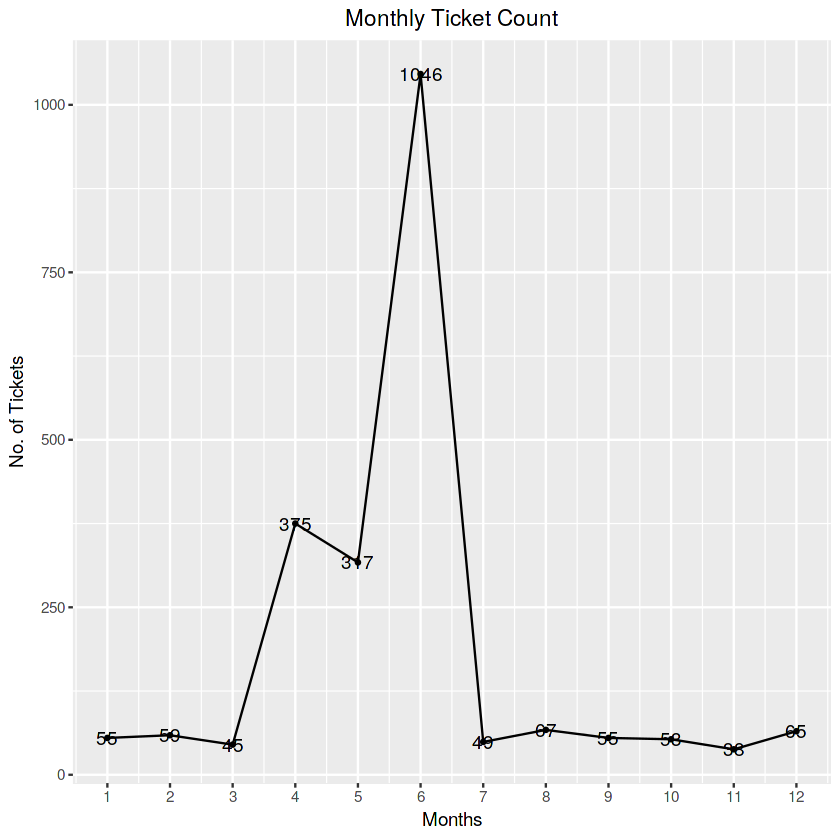

In [8]:
ggplot(data = monthly_count,aes(Month,Count,label = Count))+
        geom_line()+
        geom_point(size = 0.8)+
        geom_text()+
        scale_x_continuous(breaks = monthly_count$Month)+
        labs(title = "Monthly Ticket Count",x= "Months",y ="No. of Tickets")+
        theme(plot.title = element_text(hjust = 0.5))

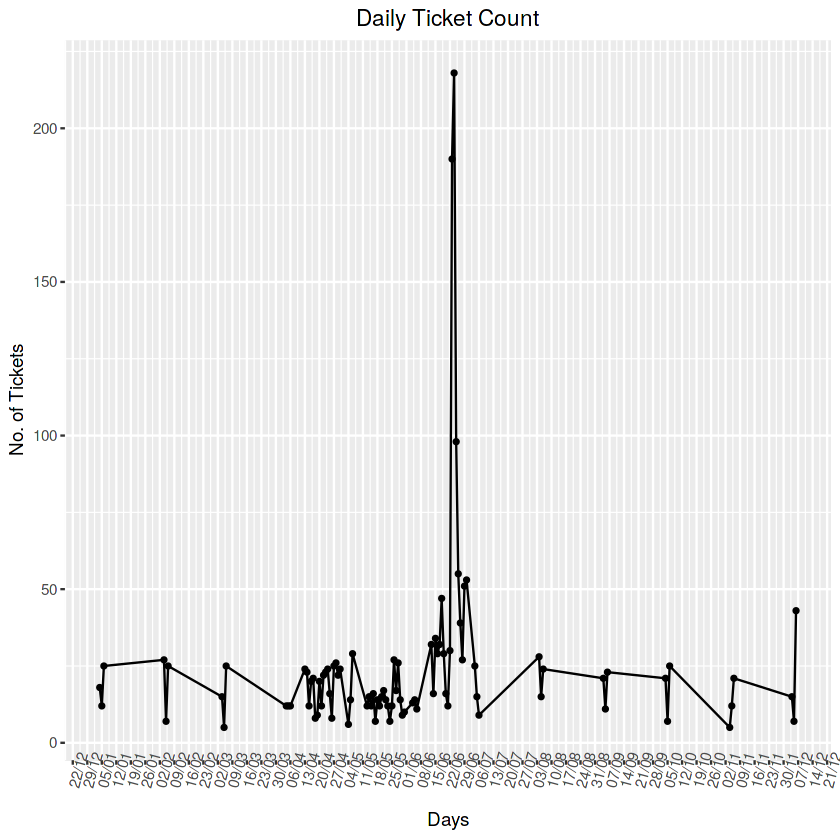

In [9]:
ggplot(data = daily_count,aes(as.POSIXct(Date),Count))+
        geom_line()+
        geom_point(size = 1)+
        scale_x_datetime(breaks = "1 weeks",date_labels = "%d/%m")+
        labs(title = "Daily Ticket Count",x= "Days",y ="No. of Tickets")+
        theme(axis.text.x = element_text(angle = 75),
              plot.title = element_text(hjust = 0.5))

In [10]:
# Complaint Type Processing
network_tickets<- contains(comcast_data$CustomerComplaint,match = 'network',ignore.case = T)
internet_tickets<- contains(comcast_data$CustomerComplaint,match = 'internet',ignore.case = T)
billing_tickets<- contains(comcast_data$CustomerComplaint,match = 'bill',ignore.case = T)
email_tickets<- contains(comcast_data$CustomerComplaint,match = 'email',ignore.case = T)
charges_ticket<- contains(comcast_data$CustomerComplaint,match = 'charge',ignore.case = T)

comcast_data$ComplaintType[internet_tickets]<- "Internet"
comcast_data$ComplaintType[network_tickets]<- "Network"
comcast_data$ComplaintType[billing_tickets]<- "Billing"
comcast_data$ComplaintType[email_tickets]<- "Email"
comcast_data$ComplaintType[charges_ticket]<- "Charges"

comcast_data$ComplaintType[-c(internet_tickets,network_tickets,
                              billing_tickets,charges_ticket,email_tickets)]<- "Others"

table(comcast_data$ComplaintType)


 Billing  Charges    Email Internet  Network   Others 
     363      139       16      472        1     1233 

In [11]:
open_complaints<- (comcast_data$Status == "Open"| comcast_data$Status =="Pending")
closed_complaints<-(comcast_data$Status == "Closed"| comcast_data$Status =="Solved")
comcast_data$ComplaintStatus[ open_complaints]<-"Open" 
comcast_data$ComplaintStatus[closed_complaints]<- "Closed" 

#  Creating Stacked barchart for complaints based on State and Status

`summarise()` regrouping output by 'State' (override with `.groups` argument)



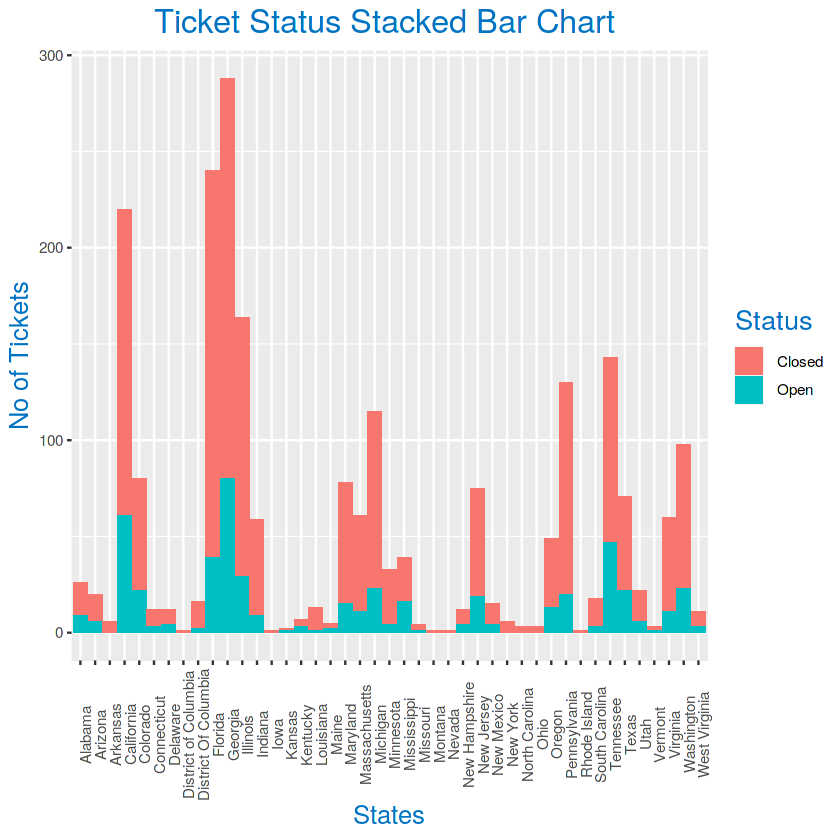

In [12]:
comcast_data<- group_by(comcast_data,State,ComplaintStatus)
chart_data<- summarise(comcast_data,Count = n())
ggplot(as.data.frame(chart_data) ,mapping = aes(State,Count))+
      geom_col(aes(fill = ComplaintStatus),width = 0.95)+
      theme(axis.text.x = element_text(angle = 90),
            axis.title.y = element_text(size = 15),
            axis.title.x = element_text(size = 15),
            title = element_text(size = 16,colour = "#0073C2FF"),
            plot.title = element_text(hjust =  0.5))+
      labs(title = "Ticket Status Stacked Bar Chart ",
           x = "States",y = "No of Tickets",
           fill= "Status")

In [13]:
chart_data%>%
            filter(ComplaintStatus == "Open")->
            open_complaints
open_complaints[open_complaints$Count == max(open_complaints$Count),c(1,3)]

State,Count
<fct>,<int>
Georgia,80


In [14]:
resolved_data <- group_by(comcast_data,ComplaintStatus)
total_resloved<- summarise(resolved_data ,percentage =(n()/nrow(resolved_data))) 
resolved_data <- group_by(comcast_data,ReceivedVia,ComplaintStatus)
Category_resloved<- summarise(resolved_data ,percentage =(n()/nrow(resolved_data))) 

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'ReceivedVia' (override with `.groups` argument)



# Ploting Pie Chart for Total Resolved Vs Category Resolved

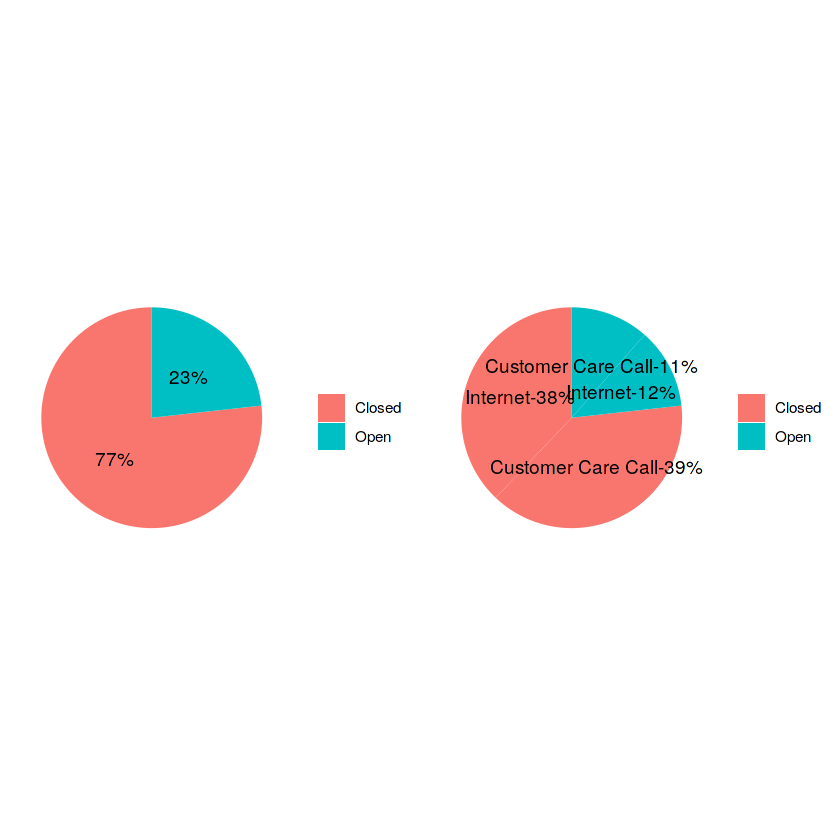

In [15]:
par(mfrow = c(1,2))
total<-ggplot(total_resloved,
       aes(x= "",y =percentage,fill = ComplaintStatus))+
      geom_bar(stat = "identity",width = 1)+
      coord_polar("y",start = 0)+
      geom_text(aes(label = paste0(round(percentage*100),"%")),
                position = position_stack(vjust = 0.5))+
      labs(x = NULL,y = NULL,fill = NULL)+
      theme_classic()+theme(axis.line = element_blank(),
                            axis.text = element_blank(),
                            axis.ticks = element_blank())

# Pie Chart for Category wise Ticket Status
category<-ggplot(Category_resloved,
       aes(x= "",y =percentage,fill = ComplaintStatus))+
      geom_bar(stat = "identity",width = 1)+
      coord_polar("y",start = 0)+
      geom_text(aes(label = paste0(ReceivedVia,"-",round(percentage*100),"%")),
                position = position_stack(vjust = 0.5))+
      labs(x = NULL,y = NULL,fill = NULL)+
      theme_classic()+theme(axis.line = element_blank(),
                            axis.text = element_blank(),
                            axis.ticks = element_blank())
ggarrange(total,category,nrow = 1, ncol = 2)